# Customer Purchasing Behavior Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline

###### Importing Data For Processing and Cleaning

In [2]:
trans = pd.read_csv('QVI_transaction_data.csv')
cust = pd.read_csv('QVI_purchase_behaviour.csv')

Our data is divided in two datasets, Transactions Dataset and Customer Dataset

#### Merging Datasets Together.

In [3]:
df = pd.merge(trans, cust, on='LYLTY_CARD_NBR', how='left')

In [4]:
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


#### Data Cleaning

In [5]:
df['DATE'] = pd.to_datetime((df['DATE'] - 25569) * 86400.0, unit='s')

In [6]:
df.DATE.dt.year.unique() # We have two Years of Data

array([2018, 2019], dtype=int64)

In [7]:
df.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
std,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226
min,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


Removing Outlier in Total Sales Column

In [8]:
upper = df['TOT_SALES'].quantile(0.25) + 1.5*df['TOT_SALES'].quantile(0.75)

In [9]:
df.shape

(264836, 10)

In [10]:
df2 = df[-(df['TOT_SALES'] >= upper)]

c:\users\memon\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TOT_SALES', ylabel='Density'>

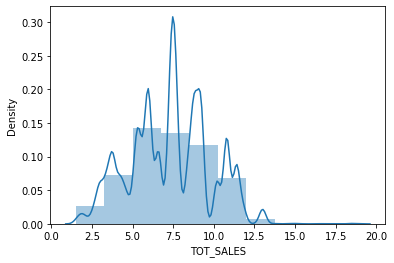

In [11]:
sns.distplot(df2.TOT_SALES,bins=10)

#### Feature Engineering

In [12]:
df2.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


We have PROD_NAME in data, in which product weight is written, so extracting them, will be helpful for analysis.

In [13]:
def GetProductWeight(dataframe):
    ls = []
    ys = []
    for val in dataframe:
        x = re.findall('[0-9]+[g|G]', val)[0]
        ls.append(x)
    for i in ls:
        y = i.split('g')
        z = y[0].split('G')
        ys.append(z[0])
    return ys

In [14]:
df2['Prod_Weig (g)'] = GetProductWeight(df2['PROD_NAME'])

<ipython-input-14-1265de6c4fb5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Prod_Weig (g)'] = GetProductWeight(df2['PROD_NAME'])


Extracting Brand Names for Product Name

In [15]:
branddict = {'CCS':'CC\'s','DORITO':'DORITOS','BURGER':'BURGER RINGS','FRENCH':'FRENCH FRIES',
             'GRAIN':'GRAIN WAVES','GRNWVES':'GRAIN WAVES','INFZNS':'INFUZIONS','NATURAL':'THE NATURAL CHIP COMPANY',
             'NCC':'THE NATURAL CHIP COMPANY','OLD':'OLD EL PASO','RED':'RED ROCK DELI','RRD':'RED ROCK DELI',
             'SMITH':'SMITH CRINKLE','SMITHS': 'SMITH CRINKLE','SNBTS':'SUNBITES','WW':'WOOLWORTHS' 
}
def GetProductBrand(dataframe):
    zs = []
    for i in dataframe:
        y = i.split(' ')[0].upper()
        vl = branddict.get(y)
        if vl != None:
            zs.append(vl)
        else:
            zs.append(y)
    return zs

In [16]:
df2["PROD_BRAND"]=GetProductBrand(df2['PROD_NAME'])

<ipython-input-16-b3adb4bf1745>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["PROD_BRAND"]=GetProductBrand(df2['PROD_NAME'])


In [17]:
df2['Year'] = df2.DATE.dt.year
df2['Month'] = df2.DATE.dt.month_name()
df2['Day'] = df2.DATE.dt.day_name()

<ipython-input-17-8ab714adba90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Year'] = df2.DATE.dt.year
<ipython-input-17-8ab714adba90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month'] = df2.DATE.dt.month_name()
<ipython-input-17-8ab714adba90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [18]:
df2.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,Prod_Weig (g),PROD_BRAND,Year,Month,Day
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,THE NATURAL CHIP COMPANY,2018,October,Wednesday
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,CC's,2019,May,Tuesday
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,SMITH CRINKLE,2019,May,Monday
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,175,SMITH CRINKLE,2018,August,Friday
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget,150,KETTLE,2018,August,Saturday


### Exploratory Data Analysis

c:\users\memon\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DATE', ylabel='TOT_SALES'>

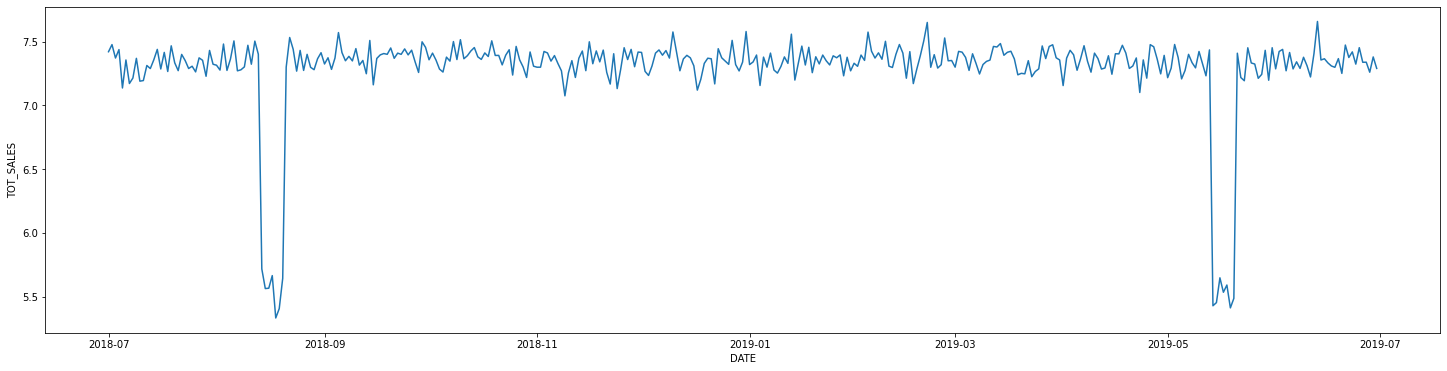

In [19]:
plt.figure(figsize=(25,6))
sns.lineplot(df2.DATE,df2.TOT_SALES,ci=None)

c:\users\memon\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Year', ylabel='TOT_SALES'>

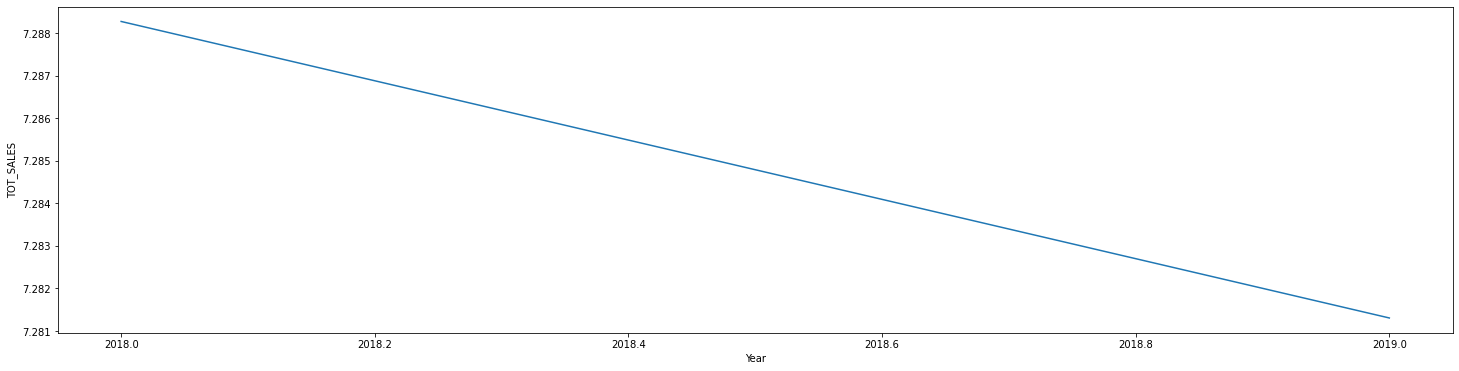

In [20]:
plt.figure(figsize=(25,6))
sns.lineplot(df2.Year,df2.TOT_SALES,ci=None)

In this chart, it shows the overall trend is declining, but that is not true, in upper chart, sales have some significant decline in the mid of the year, thats why chart shows decline

<AxesSubplot:xlabel='TOT_SALES', ylabel='PROD_BRAND'>

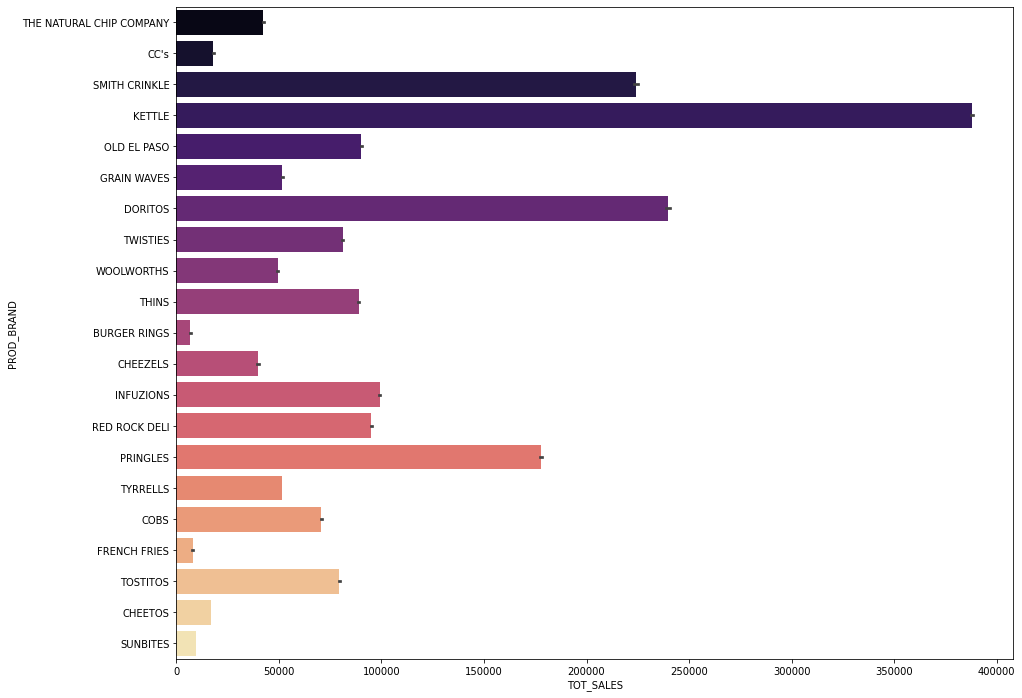

In [21]:
plt.figure(figsize=(15,12))
sns.barplot(x=df2.TOT_SALES,y=df2.PROD_BRAND,estimator=sum,palette = 'magma')

Total Sales Comparison of Each Brand

As we see KETTLE is doing well while BURGER RINGS are doing not too good.

<AxesSubplot:xlabel='TOT_SALES', ylabel='PROD_NAME'>

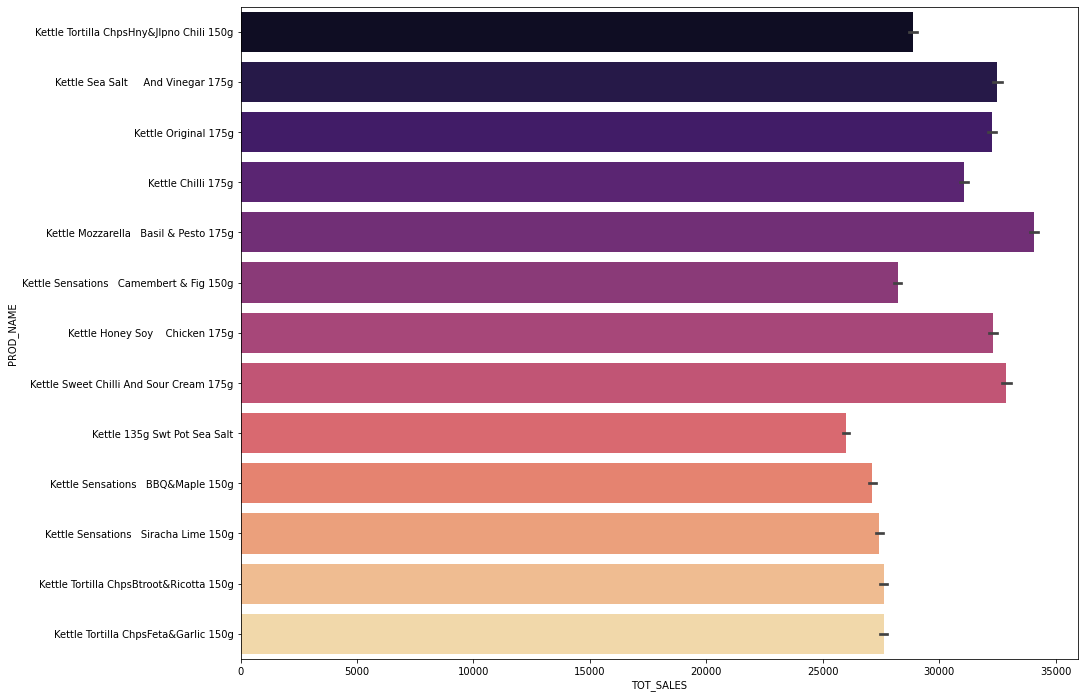

In [22]:
plt.figure(figsize=(15,12))
sns.barplot(x=df2[df2.PROD_BRAND == 'KETTLE'].TOT_SALES,y=df2[df2.PROD_BRAND == 'KETTLE'].PROD_NAME,estimator=sum,palette = 'magma')

Every KETTLE chips is doing well

<AxesSubplot:xlabel='TOT_SALES', ylabel='LIFESTAGE'>

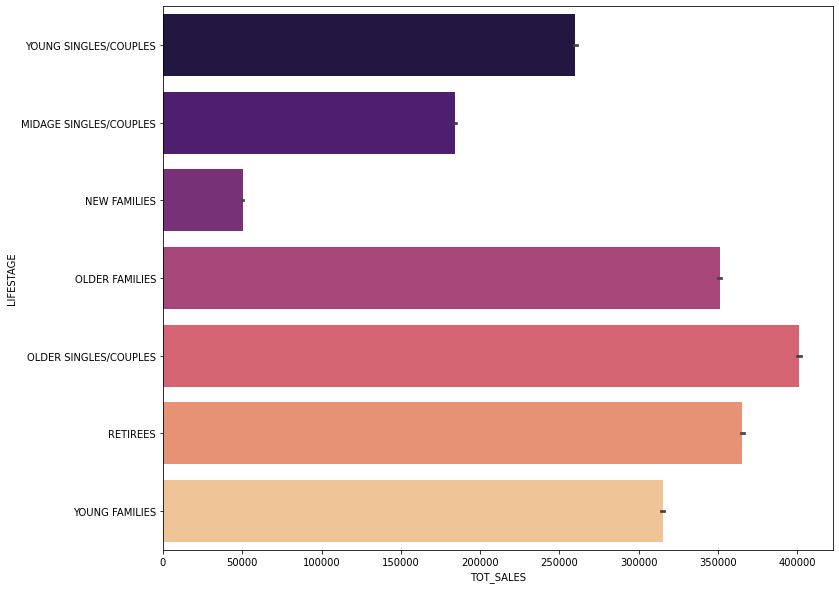

In [23]:
plt.figure(figsize=(12,10))
sns.barplot(x=df2.TOT_SALES,y=df2.LIFESTAGE,estimator=sum,palette = 'magma')

If We see that Age of person is Postive correlated to Sales of Chips, we can see in this chart old people are more buying as compared to younger ones

Text(0.5, 1.0, 'Product Weight (grams)')

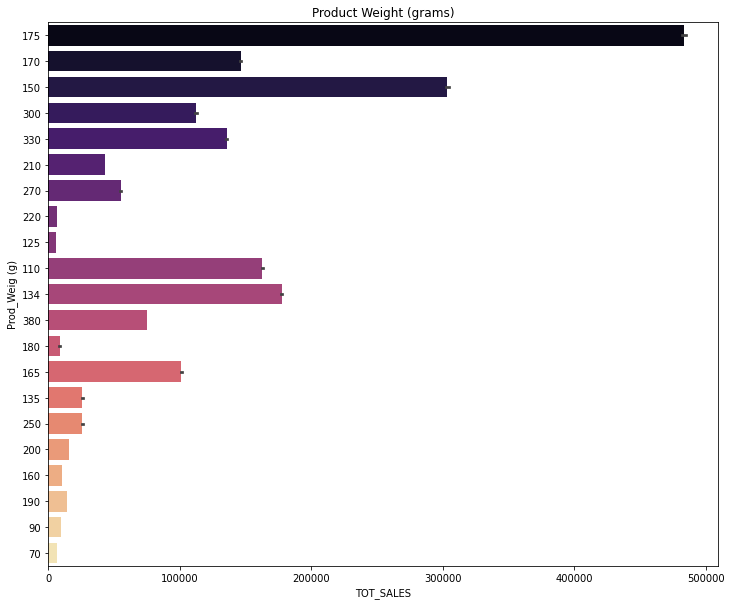

In [24]:
plt.figure(figsize=(12,10))
sns.barplot(x=df2.TOT_SALES,y=df2['Prod_Weig (g)'],estimator=sum,palette = 'magma')
plt.title('Product Weight (grams)')

product weight of 175g is good at selling

<AxesSubplot:xlabel='TOT_SALES', ylabel='PREMIUM_CUSTOMER'>

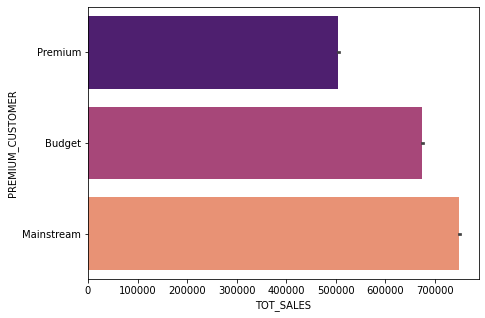

In [25]:
plt.figure(figsize=(7,5))
sns.barplot(x=df2.TOT_SALES,y=df2['PREMIUM_CUSTOMER'],estimator=sum,palette = 'magma')

<AxesSubplot:xlabel='PROD_QTY', ylabel='TOT_SALES'>

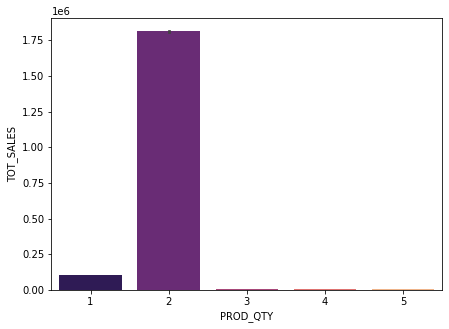

In [26]:
plt.figure(figsize=(7,5))
sns.barplot(y = df2.TOT_SALES,x = df2['PROD_QTY'],estimator=sum,palette = 'magma')

Customer who is buying chips are tend to buy two chips packets as compared

c:\users\memon\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

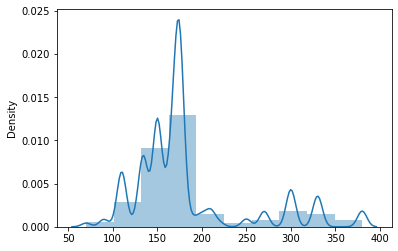

In [27]:
sns.distplot(x=df2['Prod_Weig (g)'].apply(lambda x:int(x)),bins=10,kde=True)

Most buying packet size are from 150 g to 180g 

<AxesSubplot:xlabel='TOT_SALES', ylabel='Day'>

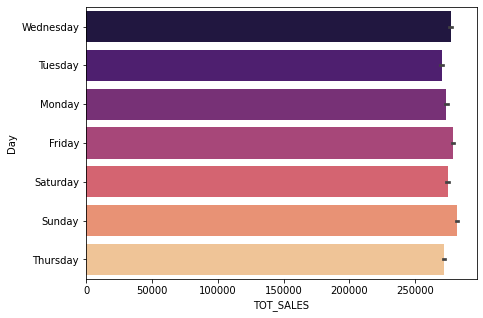

In [28]:
plt.figure(figsize=(7,5))
sns.barplot(x=df2.TOT_SALES,y=df2['Day'],estimator=sum,palette = 'magma')

Sales on Different days on week does seem to be have some strong Difference

Text(0.5, 0, 'Total Sales')

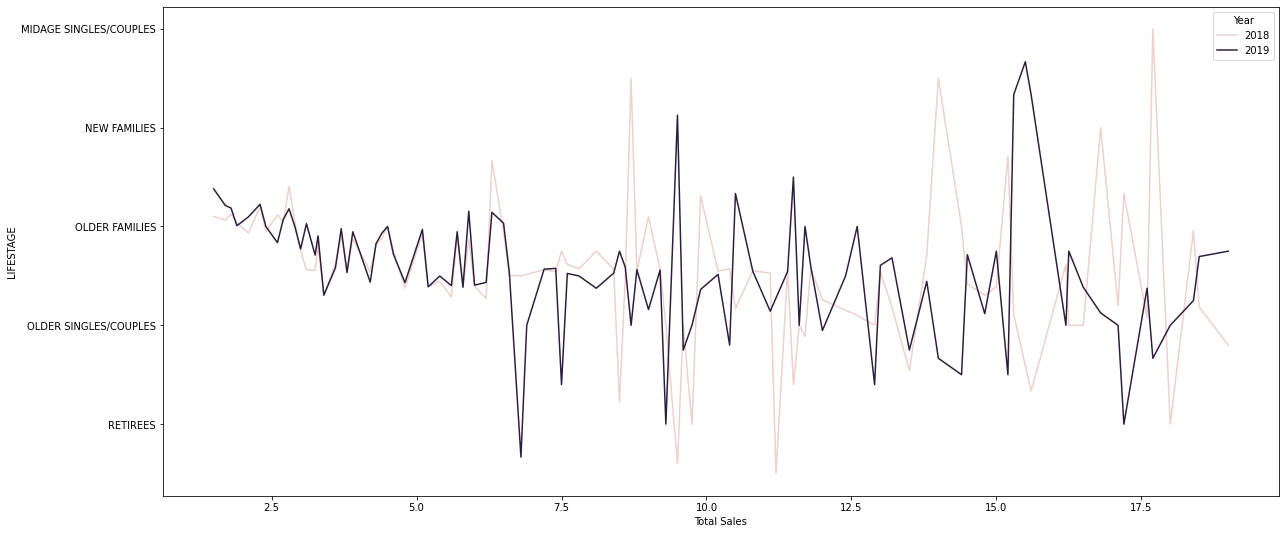

In [29]:
plt.figure(figsize=(20,9))
sns.lineplot(data=df2, x='TOT_SALES',y='LIFESTAGE',ci=None,hue='Year')
plt.xlabel('Total Sales')

## Recomendations

- We have Saw there our Most of Sales Coming From Mainstream, who are mostly Old in Age,the reason why younger generation have not buying too much packets of chips are based on different factors, like some are health or diet concisous, some like burger and pizza, For Attracting Young Persons we should do Some Marketing Campaign to grab there attention more.
- As we see in chart above, Twice Number of Packets sold most of the time, to increase customer purchases, we can have offer of 1 with 1 free, to attract more customers.
- Our Customer Favourite Chips Brand is Kettle, Doritos and Smith Crinkle, Creating Some Percent sales for a time limit, can be helpfull in increasing Sales.
- The Most Bought Chip Size Packet is from 150 g to 180 grams, customer are not buying much packet bigger than 180 grams, we can use some discount code or coupon code offer to buying bigger Packets, can help us to increase sales.